## Falco Physical Trait Data Phylogenetic Signaling Analysis 

We want to analyze the Falco genus, which contains roughly 40 species based on classical taxonomy. For this mini study, we want to examine physical data, including body length, body weight (male and female), and wingspan. We want to determine how these physical phenotypes correlate with taxonomy for this genus.


We will create a phylogeny using the COI genetic marker. Falcon species will be searched on the NCBI nucleotide database based on this marker. One COI sequence per unique species will be used in an alignment, which will then be used to create a distance matrix and a phylogenetic tree. The phylogenetic tree will be created using maximum likelihood methods and bootstrapping to indicate confidence values will also be performed. 


Continuous trait mapping, using the stochastic mapping tools in the phytools package, will be done on the phylogenetic tree to give a visual representation of trait evolution based on the determined phylogeny. A quantitative approach to determining how the traits are correlated to the phylogeny will be used, and Moran's I spatial autocorrelation coefficient will be determined. If the coefficient is 0, this indicates that for the given trait, species close to each other resemble each other as predicted by random chance. If it is less than 0, they resemble each other less than that predicted by random chance, indicating closely related species differ more on this trait. It it is greater than 0, the converse is true, where closely related species are more similar based on this trait as compared to random chance. 


We will hypothesize that the physical traits in question (body length, wingspan, male and female weight) will exhibit a greater similarity amongst closely related species. In this case, we expect to see a phylogenetic signal significantly greater than 0 in the case of Moran's I coefficient. Trait mapping and phylogenetic signal will be determined for all four the of the physical traits indicated. 


Let's begin by loading some necessary libraries. If you do not have any of these libraries, they can be installed using 'install.packages()'. 

***

In [2]:
library(picante)

library(ape)

library(adephylo)

library(ade4)

library(phylobase)

library(geiger)

library(phytools)

library(rentrez)

library(tidyverse)

library(seqinr)

library(muscle)

library(Biostrings)

library(stringr)

library(ape)

library(DECIPHER)

library(phytools)

library(phangorn)

library(stringi);

We want to search for data on the Falco genus. We will use the NCBI nucleotide database, as the BOLD database does not have many records for 14 bins, and we want to get as close as we can to the total number of species in the genus as possible, as that will give us a complete phylogenetic picture.



Let's use the rentrez package to search the database for the COI region based on the Falco genus.

In [3]:
falco_search <- entrez_search(db = "nuccore", term = "(Falco[ORGN] AND 600:750[Sequence Length] AND COI NOT WHOLE NOT COMPLETE NOT UNVERIFIED", retmax = 10000)



falco_search$count

[1] 115

It looks like we have 115 hits. That's quite a lot, let's fetch these and start filtering them.

In [4]:
falco_fetch <- entrez_fetch(db = "nuccore", id = falco_search$ids, rettype = "fasta")

We can append our results to a fasta file and then read them into a dataframe.

In [5]:
write(falco_fetch, "falco.fasta", sep = "\n") 

falco_dna <- readDNAStringSet("falco.fasta") 

Now that we've written the results to a fasta file and the sequence data to a dataframe, we can begin creating a dataframe that indicates the species and a unique ID identifier from NCBI. We can use the word function for this, which will separate out what we need from the long identification column. 

In [9]:
falco_coi <- data.frame(falco_data = names(falco_dna), falco_seq = paste(falco_dna))

falco_coi$species_name <- word(falco_coi$falco_data, 2L, 3L)

falco_coi$uniq_id <- word(falco_coi$falco_data, 1L)

falco_coi <- falco_coi[, c("species_name", "uniq_id", "falco_seq")];

Great, now we have a dataframe with the species names, unique NCBI accession identifier and the nucleotide sequence. Let's check how many unique species and sequences we have.

In [10]:
length(unique(falco_coi$species_name))

length(unique(falco_coi$falco_seq))

[1] 17

[1] 94

We have 17 unique species and 94 unique nucleotide sequences. We would've done worse if we used the BOLD database, as that only contained 14 bins. However, we are still lacking 23 species based on classical taxonomy. This will hinder our analysis, as we will be making the assumption that our phylogeny would represent the theoretical complete phylogeny using the 40 species. However, we cannot proceed without making this assumption, as we require sequence alignment data for many of the downstream analyses. This will in fact limit our analysis, and effects of this assumption will be discussed after the results are ascertained.



We would like to select one sequence per unique Falco species. We can cluster these sequences into OTUs, but this might end up putting similar species into the same OTU, and therefore we will avoid this approach. We can shuffle our dataframe and then pick the first unique value for the species.

In [11]:
falco_coi_shuff <- falco_coi[sample(nrow(falco_coi)),]

falco_coi_uniq <- distinct(falco_coi_shuff, species_name, .keep_all = TRUE)

Our dataframe falco_coi_uniq contains one sequence per species. Now we can use the muscle library for alignment. We will use no optimizations as we want the best alignment possible.

In [12]:
falco_coi_align <- DNAStringSet(muscle::muscle(DNAStringSet(falco_coi_uniq$falco_seq)))


MUSCLE v3.8.31 by Robert C. Edgar

http://www.drive5.com/muscle
This software is donated to the public domain.
Please cite: Edgar, R.C. Nucleic Acids Res 32(5), 1792-97.

file357c6012a5c 17 seqs, max length 745, avg  length 670
2022 MB(21%)00:00:00                Iter   1  100.00%  K-mer dist pass 1
2022 MB(21%)00:00:00                Iter   1  100.00%  K-mer dist pass 2
2022 MB(21%)00:00:00                Iter   1  100.00%  Align node
2022 MB(21%)00:00:00                Iter   1  100.00%  Root alignment
2022 MB(21%)00:00:00                Iter   2  100.00%  Refine tree
2022 MB(21%)00:00:00                Iter   2  100.00%  Root alignment
2022 MB(21%)00:00:00                Iter   2  100.00%  Root alignment
2022 MB(21%)00:00:00                Iter   3  100.00%  Refine biparts


Let's reassign our species names to our alignment, as this will save us a lot of trouble when converting back and forth between data types.

In [13]:
names(falco_coi_align) <- falco_coi_uniq$species_name

Now we can determine the DNA distance using the ape library. We will use the Kimura-80 model of DNA evolution as we want to optimize our distance based on evolution, because we will be using it to create a phylogenetic tree.

In [14]:
falco_coi_dist <- dist.dna((as.DNAbin(falco_coi_align)), model = "K80", as.matrix = TRUE, 

                           pairwise.deletion = TRUE)

Let's ensure that everything went smoothly and check our distance matrix. 

In [16]:
falco_coi_dist

,Falco rupicoloides,Falco tinnunculus,Falco femoralis,Falco columbarius,Falco peregrinus,Falco mexicanus,Falco sparverius,Falco biarmicus,Falco naumanni,Falco amurensis,Falco subbuteo,Falco rusticolus,Falco vespertinus,Falco rufigularis,Falco eleonorae,Falco longipennis,Falco cenchroides
Falco rupicoloides,0.00000000,0.07059116,0.08962599,0.08766904,0.09004204,0.09944279,0.09828782,0.093563017,0.08626789,0.08793393,0.08949690,0.093563017,0.09387432,0.09952730,0.09342619,0.09158302,0.07784700
Falco tinnunculus,0.07059116,0.00000000,0.09236133,0.08525217,0.10017160,0.09233131,0.09306909,0.091348206,0.07779788,0.08786859,0.08315445,0.090440554,0.09148685,0.08983712,0.08496605,0.08302516,0.01069433
Falco femoralis,0.08962599,0.09236133,0.00000000,0.09715446,0.09612170,0.07842193,0.08570781,0.098150115,0.11196930,0.08736951,0.09176367,0.093851124,0.09650865,0.09115378,0.08812066,0.09577093,0.08909410
Falco columbarius,0.08766904,0.08525217,0.09715446,0.00000000,0.08678423,0.09686020,0.09871584,0.092725897,0.08250978,0.08408752,0.09372105,0.090058030,0.09478303,0.09675916,0.09188619,0.09785923,0.07957371
Falco peregrinus,0.09004204,0.10017160,0.09612170,0.08678423,0.00000000,0.04749886,0.09757899,0.041706980,0.11389376,0.10205484,0.09227879,0.041640147,0.11042851,0.10969769,0.09044055,0.09910608,0.09766225
Falco mexicanus,0.09944279,0.09233131,0.07842193,0.09686020,0.04749886,0.00000000,0.08264701,0.056590280,0.12151113,0.08207996,0.08796154,0.050713515,0.08711885,0.08736891,0.08981339,0.09332115,0.09208612
Falco sparverius,0.09828782,0.09306909,0.08570781,0.09871584,0.09757899,0.08264701,0.00000000,0.095226612,0.11583258,0.08223834,0.10107100,0.091361960,0.09743620,0.07858562,0.10515681,0.10384732,0.09873921
Falco biarmicus,0.09356302,0.09134821,0.09815011,0.09272590,0.04170698,0.05659028,0.09522661,0.000000000,0.09694699,0.09149523,0.08838403,0.003100785,0.09308199,0.09876634,0.09020885,0.09478303,0.08597100
Falco naumanni,0.08626789,0.07779788,0.11196930,0.08250978,0.11389376,0.12151113,0.11583258,0.096946987,0.00000000,0.08130348,0.08705921,0.092573968,0.07708263,0.10308534,0.09257397,0.08025274,0.07898330
Falco amurensis,0.08793393,0.08786859,0.08736951,0.08408752,0.10205484,0.08207996,0.08223834,0.091495234,0.08130348,0.00000000,0.08678423,0.088609050,0.01577599,0.08274072,0.09227879,0.09436602,0.08588467


Great, we have everything ready to create our tree. However, let's just first convert our alignment data to DNAbin, and then to phyDat, as we will need the alignment data in this format for our tree optimization and trait evolution mapping steps.   

In [17]:
falco_coi_phy <- as.phyDat(as.DNAbin(falco_coi_align))

Now we can use the phangorn library to create a simple neighbor joining tree as our first step.

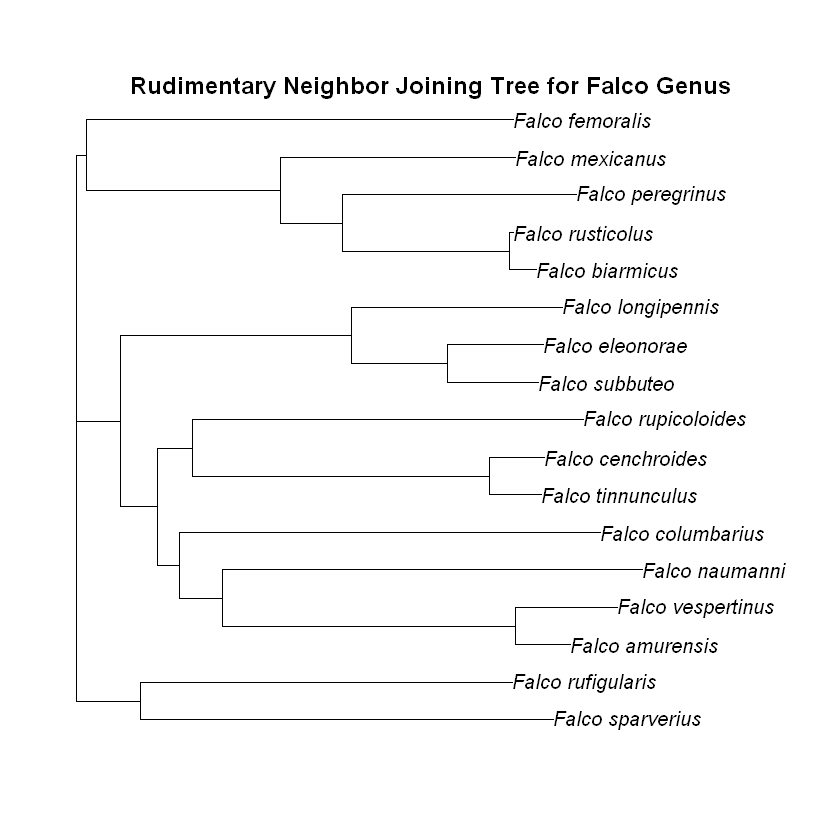

In [18]:
par(mar = c(1,1,1,1), oma = c(3,1,3,0))

tree=NJ(falco_coi_dist)

plot(tree, main="Rudimentary Neighbor Joining Tree for Falco Genus")

Great, now that we have our starting tree, we can use the phangorn package to call on maximum likelihood estimation methods. We can first test our alignment data and tree using the modelTest() function to determine the optimal model for our data.  

In [19]:
mt <- modelTest(object = falco_coi_phy, tree = tree)

mt

[1] "JC+I"
[1] "JC+G"
[1] "JC+G+I"
[1] "F81+I"
[1] "F81+G"
[1] "F81+G+I"
[1] "K80+I"
[1] "K80+G"
[1] "K80+G+I"
[1] "HKY+I"
[1] "HKY+G"
[1] "HKY+G+I"
[1] "SYM+I"
[1] "SYM+G"
[1] "SYM+G+I"
[1] "GTR+I"
[1] "GTR+G"
[1] "GTR+G+I"


Model,df,logLik,AIC,AICw,AICc,AICcw,BIC
JC,31,-3191.313,6444.627,2.003958e-198,6447.409,3.799173e-198,6587.642
JC+I,32,-3052.024,6168.048,2.291523e-138,6171.015,3.963130e-138,6315.677
JC+G,32,-3050.278,6164.556,1.313995e-137,6167.522,2.272520e-137,6312.184
JC+G+I,33,-3050.747,6167.493,3.024948e-138,6170.649,4.757862e-138,6319.735
F81,34,-3156.847,6381.695,9.277457e-185,6385.047,1.323010e-184,6538.550
F81+I,35,-3009.985,6089.971,2.062656e-121,6093.525,2.658620e-121,6251.439
F81+G,35,-3007.258,6084.517,3.153371e-120,6088.071,4.064475e-120,6245.985
F81+G+I,36,-3007.292,6086.584,1.121976e-120,6090.346,1.303039e-120,6252.665
K80,32,-2924.081,5912.162,8.417132e-83,5915.128,1.455721e-82,6059.790
K80+I,33,-2772.055,5610.109,3.273719e-17,5613.266,5.149147e-17,5762.351


As we can see, mt is a dataframe indicating the log likelihood ratio for each model given our dataset. Using the recommended guidelines from the phangorn vignette, we will sort by the AICc measure, which is a goodness of fit measure. The lowest AICc will be used to select our model.

In [ ]:
mt[order(mt$AICc),]

bestmodel <- mt$Model[which.min(mt$AICc)] 

In [51]:
bestmodel

[1] "HKY+G"

Therefore, our best model is the HKY+G nucleotide substitution model, or the Hasegawa-Kishino-Yano model. Let's use this parameter and the optimal.pml() function to optimize our tree using phylogenetic maximum likelihood.

In [ ]:
env = attr(mt, "env")

fitStart = eval(get(bestmodel, env), env)

fit = optim.pml(fitStart, rearrangement = "stochastic",

                optGamma = TRUE, optInv = TRUE, model = "GTR")

In [50]:
fit


 loglikelihood: -2724.481 

unconstrained loglikelihood: -2764.155 
Proportion of invariant sites: 0.003613492 
Discrete gamma model
Number of rate categories: 4 
Shape parameter: 0.1501376 

Rate matrix:
           a          c          g          t
a  0.0000000  1.6147513 24.6264292  0.6709244
c  1.6147513  0.0000000  0.2461624 24.6485748
g 24.6264292  0.2461624  0.0000000  1.0000000
t  0.6709244 24.6485748  1.0000000  0.0000000

Base frequencies:  
0.2608255 0.3474674 0.161711 0.2299961 

Now we have our best fit with a log likelihood of roughly -2724.5 (this will vary depending on the iteration, so expect a value close to this). We have our rate matrix and base frequencies for the model as well, and the fit() object has a tree method which will give us our optimized tree. First however, we want to bootstrap our fit to give confidence values for our linkages. We can use the bootstrap.pml() function from phangorn to do this.

In [ ]:
bs = bootstrap.pml(fit, bs = 100, optNni = TRUE);

Great, now we have our bootstrapped values. Let's plot our fitted tree and bootstrapped confidence values. This will be our tree that we will use for character mapping and phylogenetic signal analysis. We can plot our tree and our bootstrapped values using the plotBS() function.

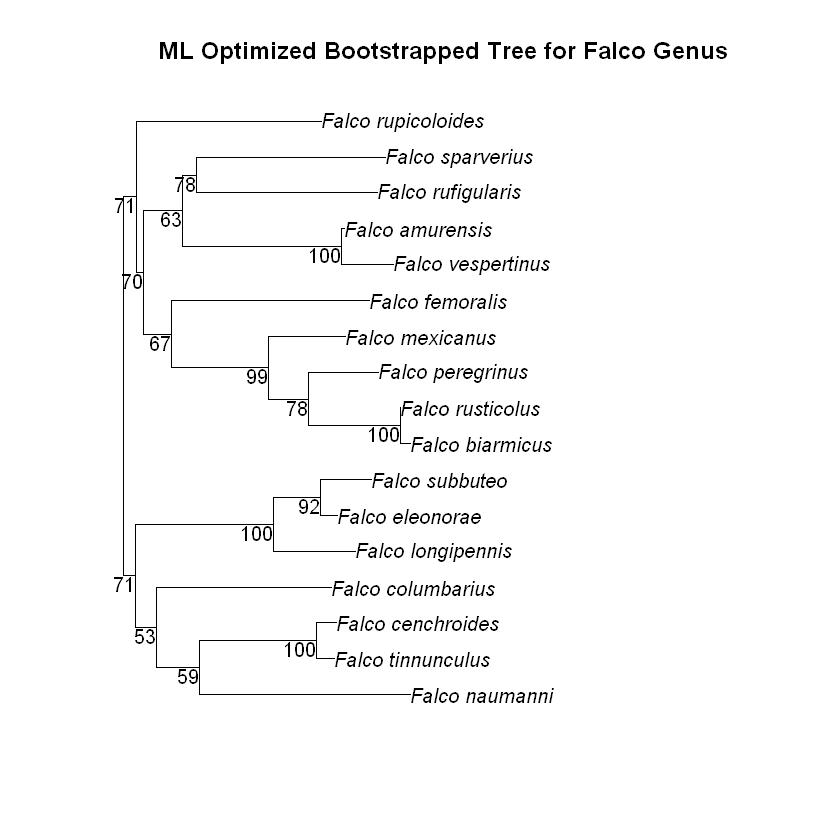

In [31]:
plotBS(midpoint(fit$tree), bs, p = 50, type = "p", main = "ML Optimized Bootstrapped Tree for Falco Genus")

We finally have our optimized tree. From the bootstrapped values, we can see that confidence is very high for many of the nodes near the base of the tree. However, there are some values that are quite low, many closer to the top of the tree. We may be able to attribute this to the fact that we don't have a complete phylogeny, as we are missing data for 23 of the species from the classical linnean taxonomy. However, separation of sister species mostly has quite high confidence values, which is a key part of our analysis. 

Trait data for the species in our dataset has been gathered from the "Handbook of the Birds of the World Alive. For all our physical traits (wingspan, weight (male and female), and length), the handbook data gave a range, and the average of the range was determined for our data, and rounded to zero decimal places. The assumption that the average of the range is the best representation of the physical traits does introduce systematic bias into our analysis. However, it was the most thorough data source available, and averages in other data resources will use the similar assumption, as bird weight can vary quite significantly for a given species. We have dropped the units, as we are using comparitive measures, however the weight is in grams, and body length and wing size are in centimeters. 


We have the trait data in a csv file titled 'falcon_trait_data.csv'. Be sure to have this file in your working directory. Let's use the read.csv() function to bring it into our environment.

In [33]:
trait <- read.csv("falcon_trait_data.csv")

trait

Species,Wingspan,Weight_females,Weight_males,Length
Falco columbarius,64,228,180,28
Falco tinnunculus,75,234,194,31
Falco sparverius,56,125,112,26
Falco longipennis,77,305,206,33
Falco subbuteo,74,241,182,32
Falco rufigularis,66,210,129,27
Falco peregrinus,97,1098,735,43
Falco rusticolus,120,1640,1110,54
Falco naumanni,66,173,131,31
Falco cenchroides,72,194,158,32


As we can see, we have a dataframe that has the trait values for each of our 17 species, in the same order as our falco_coi_uniq dataframe. We need to convert these values into numeric vectors that contain the values and the species names as the names. We will do these individually, as creating a for loop tends to introduce some issues with the numeric vector.

In [35]:
wingspan <- trait$Wingspan

wingspan <- as.numeric(wingspan)

names(wingspan) <- trait$Species



weight_m <- trait$Weight_males

weight_m <- as.numeric(weight_m)

names(weight_m) <- trait$Species



weight_f <- trait$Weight_females

weight_f <- as.numeric(weight_f)

names(weight_f) <- trait$Species



body_len <- trait$Length

body_len <- as.numeric(body_len)

names(body_len) <- trait$Species

Great, now we have our trait data as numeric vectors we can call on. Before we do the phylogenetic signaling analysis, we can use continuous trait mapping using the phytools function contMap(). We will use our optimized fit tree plotted from the midpoint, and each of our traits. 

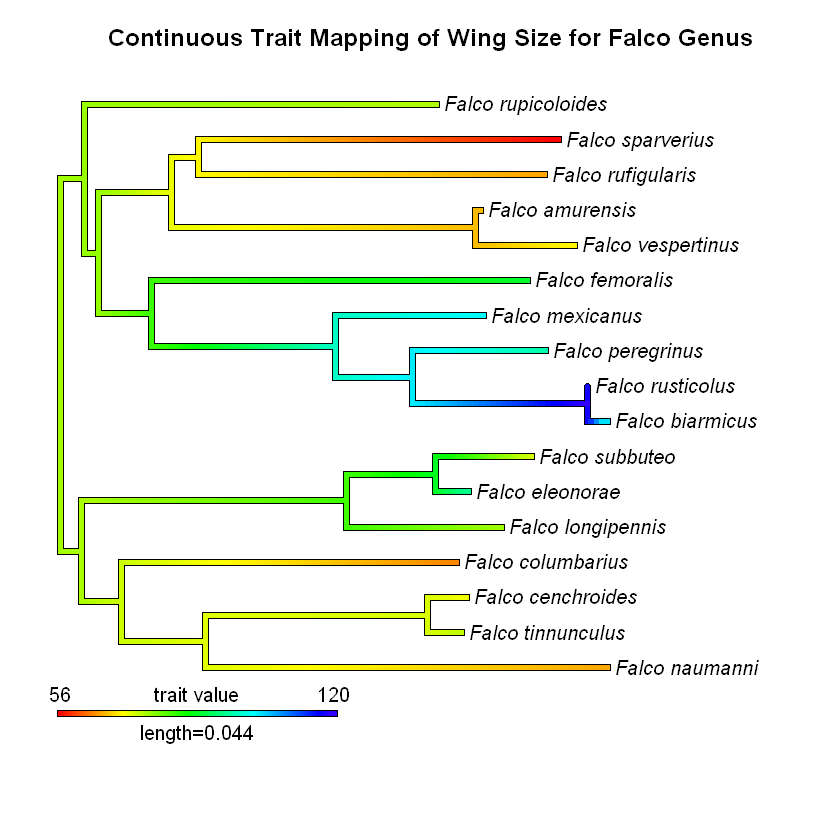

In [36]:
par(mar = c(1,1,1,1), oma = c(3,1,3,0))

wings_map <- contMap(midpoint(fit$tree),wingspan)

par(mar = c(1,1,1,1), oma = c(3,1,1,0))

title(main = "Continuous Trait Mapping of Wing Size for Falco Genus")

We now have a continuous trait mapping representation of wing size for the Falco genus. We can clearly see some patterns. The clade containing F. mexicanus, F. biarmicus, F. rusticolus, and F. peregrinus definitely exhibits wing size similarity in the sense that their wings have evolved to be larger than the other species. We see similar patterns throughout the tree, where closely related species have similarly evolved wing sizes. From this we can assume we will see a strong phylogenetic signal from Moran's I test, which should be positive as the species exhibit similarity for the trait. 


Let's conduct phylogenetic signal analysis using Moran's I test. Let's create a phylo4d object using the phylobase package and the phylo4d() function. This object combines our optimized tree and trait data, so it can be used for multivariate analysis.

In [37]:
wings_4d <- phylo4d(fit$tree, wingspan)

Warning message in asMethod(object):
"unknown attributes ignored:  RSS"

Now we can conduct Moran's test using the abouheif.moran() function from the adephylo package, which contains multivariate analysis tools for phylogenetics. The abouheif method uses a specialized matrix of phylogenetic relationships. Details on the method can be found in the references. 

In [38]:
wings_moran <- abouheif.moran(wings_4d, method = "Abouheif")

wings_moran

class: krandtest lightkrandtest 
Monte-Carlo tests
Call: as.krandtest(sim = matrix(res$result, ncol = nvar, byrow = TRUE), 
    obs = res$obs, alter = alter, names = test.names)

Number of tests:   1 

Adjustment method for multiple comparisons:   none 
Permutation number:   999 
  Test       Obs Std.Obs   Alter Pvalue
1   dt 0.6192131  4.5543 greater  0.001


We have a Moran's coefficient of approximately 0.62 (this will differ depending on run as we are using stochastic methods, but should be within 0.05), which is a moderately strong phylogenetic signal, as we predicted. We can plot this result to get a visual representation.

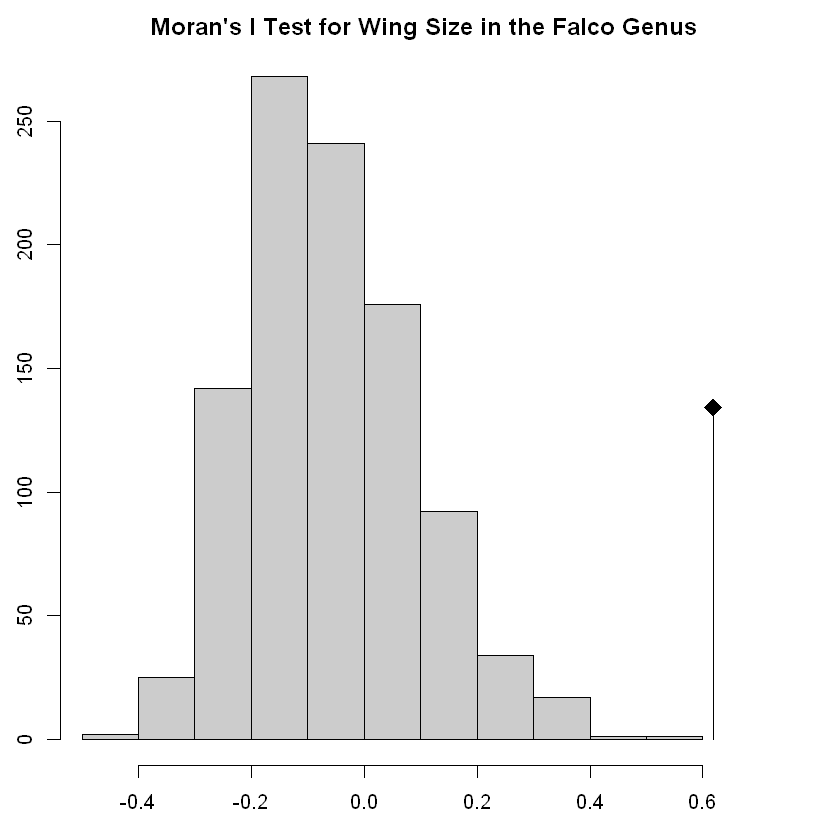

In [40]:
plot(wings_moran, main = "Moran's I Test for Wing Size in the Falco Genus")

As we can see, we have quite a strong phylogenetic signal. Therefore, we can conclude that our hypothesis is confirmed, at least for wing size. This is of course subject to the limitations of this analysis, however that will be discussed towards the end. Now we can continue the same character trait analysis for our remaining physical traits.



Let's determine phylogenetic character mapping for male body weight.

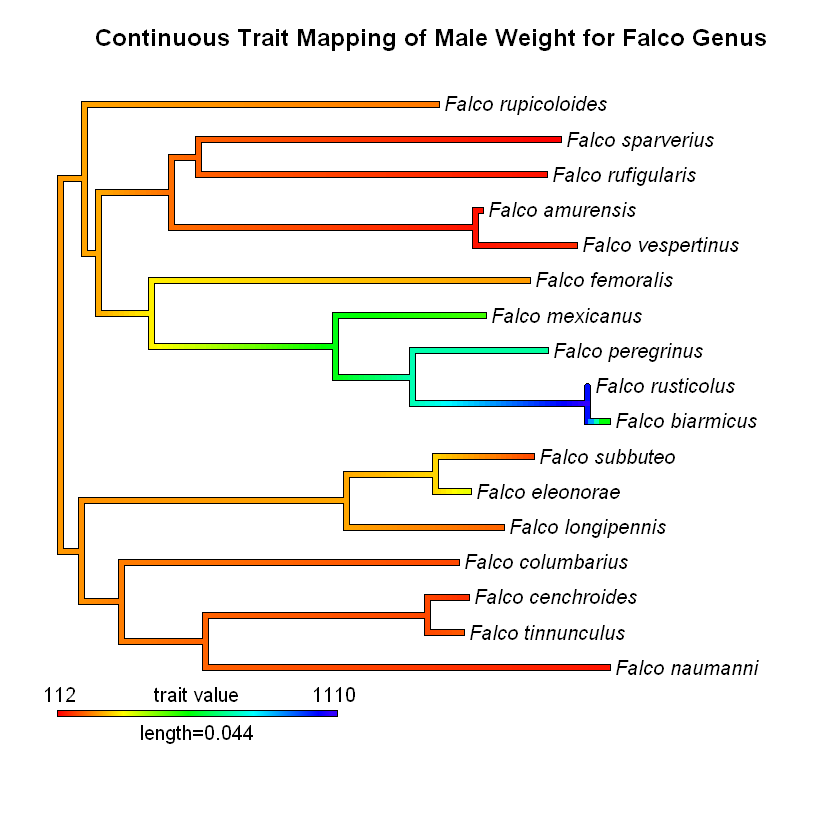

In [41]:
par(mar = c(1,1,1,1), oma = c(3,1,3,0))

weight_m_map <- contMap(midpoint(fit$tree), weight_m)

par(mar = c(1,1,1,1), oma = c(3,1,1,0))

title(main = "Continuous Trait Mapping of Male Weight for Falco Genus")

For this character trait, we do not see strong phylogenetic grouping based on the trait. We still see the grouping we discussed for the wings trait, where the group has similar weight in the sense that their weight is greater. However, for the rest of the tree, the weight is largely uniform. Therefore, we do not expect to see as strong a phylogenetic signal based on Moran's test, but we should still see a relationship. Let's conduct the test.

Warning message in asMethod(object):
"unknown attributes ignored:  RSS"

class: krandtest lightkrandtest 
Monte-Carlo tests
Call: as.krandtest(sim = matrix(res$result, ncol = nvar, byrow = TRUE), 
    obs = res$obs, alter = alter, names = test.names)

Number of tests:   1 

Adjustment method for multiple comparisons:   none 
Permutation number:   999 
  Test       Obs  Std.Obs   Alter Pvalue
1   dt 0.5716865 4.708822 greater  0.001


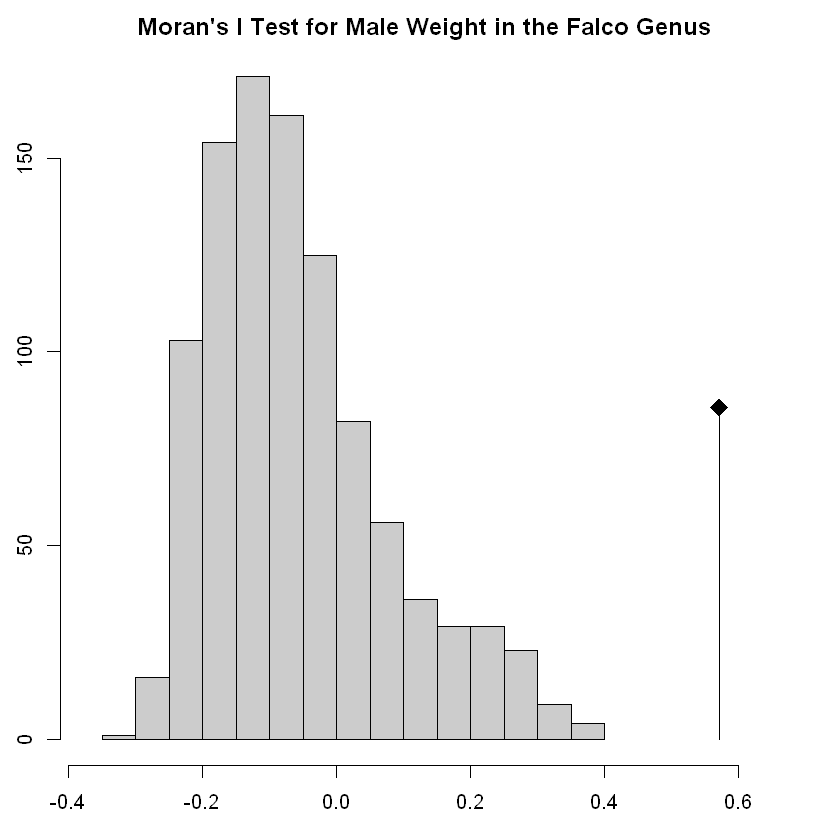

In [42]:
weight_m_4d <- phylo4d(fit$tree, weight_m)

weight_m_moran <- abouheif.moran(weight_m_4d, method = "Abouheif")

weight_m_moran

plot(weight_m_moran, main = "Moran's I Test for Male Weight in the Falco Genus")

We still see a moderately strong phylogenetic signal, with Moran's I coefficient being 0.57 roughly (again this will differ slightly depending on run), which is not what we expected based on our last result. However, based Moran's data, we can still see that there is a relationship there. Let's continue for female weight. Our intuition tells us that this should be roughly the same mapping distribution as male weight.

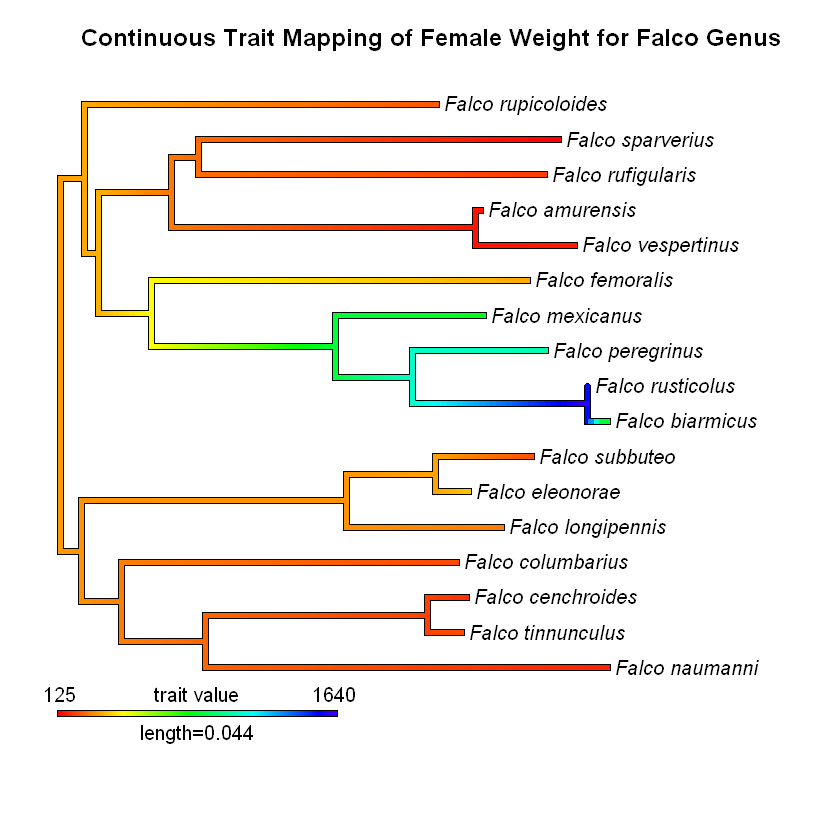

In [43]:
par(mar = c(1,1,1,1), oma = c(3,1,3,0))

weight_f_map <- contMap(midpoint(fit$tree), weight_f)

par(mar=c(1,1,1,1), oma = c(3,1,1,0))

title(main = "Continuous Trait Mapping of Female Weight for Falco Genus")

It seems that our intuition was correct, the continuous trait mapping tree is almost identical to that of male weight. The phylogenetic signal should be about the same. 

Warning message in asMethod(object):
"unknown attributes ignored:  RSS"

class: krandtest lightkrandtest 
Monte-Carlo tests
Call: as.krandtest(sim = matrix(res$result, ncol = nvar, byrow = TRUE), 
    obs = res$obs, alter = alter, names = test.names)

Number of tests:   1 

Adjustment method for multiple comparisons:   none 
Permutation number:   999 
  Test       Obs  Std.Obs   Alter Pvalue
1   dt 0.6314611 4.720149 greater  0.001


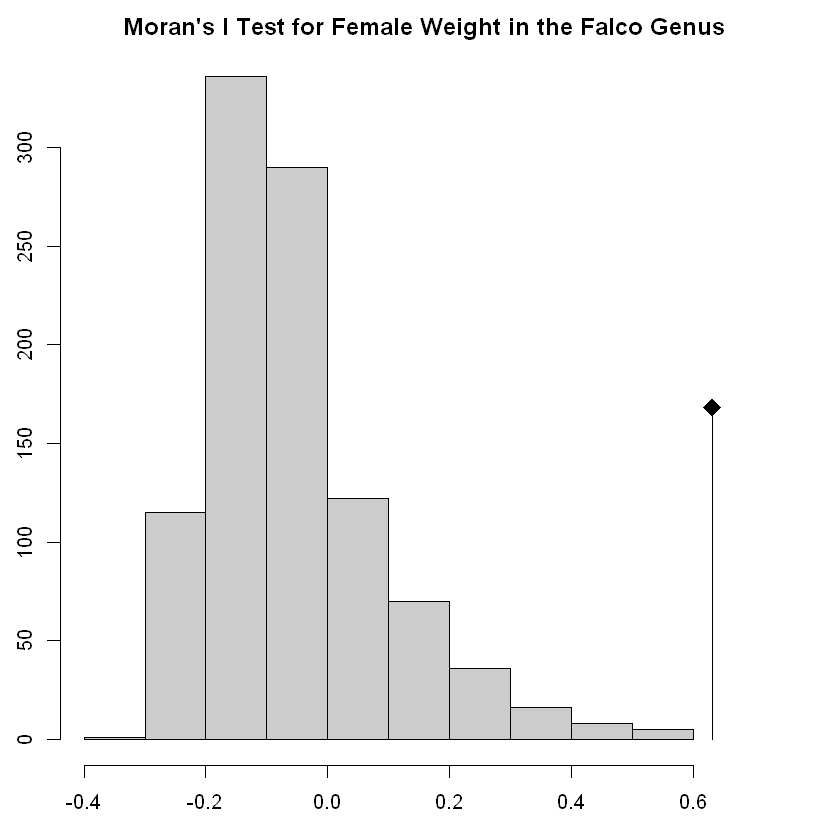

In [44]:
weight_f_4d <- phylo4d(fit$tree, weight_f)

weight_f_moran <- abouheif.moran(weight_f_4d, method = "Abouheif")

weight_f_moran

plot(weight_f_moran, main = "Moran's I Test for Female Weight in the Falco Genus")

This phylogenetic signal is much stronger - giving a 0.63 (again, will differ a bit each run) coefficient for Moran's I test. Perhaps we're losing some resolution on the continuous trait mapping, as the range is from 125-1640, which is significantly greater than the range for the male weight trait mapping. Finally, let's finish our analysis by determining the trait mapping and phylogenetic signal for the body length of the birds.

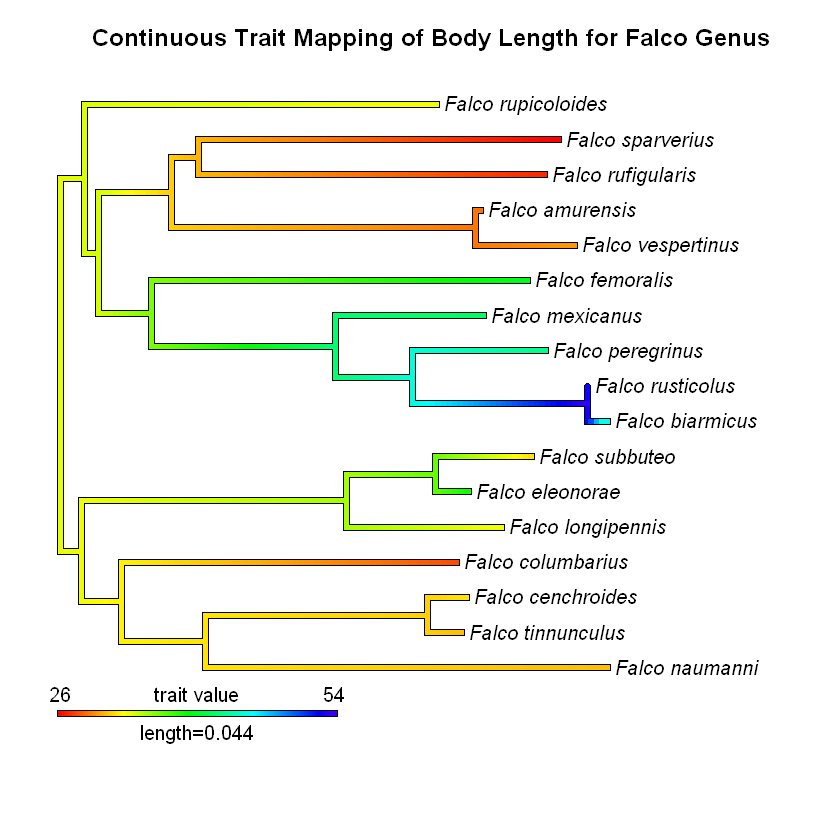

In [45]:
par(mar = c(1,1,1,1), oma = c(3,1,3,0))

length_map <- contMap(midpoint(fit$tree), body_len)

par(mar = c(1,1,1,1), oma = c(3,1,1,0))

title(main = "Continuous Trait Mapping of Body Length for Falco Genus")

We see great separation for this trait mapping. Again, the clade containing F. mexicanus indicates strong phylogenetic correlation for body length. Separation for the other members is also much better as compared to body weight. However, we don't know if this necessarily correlates with a stronger phylogenetic signal. Let's conduct Moran's I test.

Warning message in asMethod(object):
"unknown attributes ignored:  RSS"

class: krandtest lightkrandtest 
Monte-Carlo tests
Call: as.krandtest(sim = matrix(res$result, ncol = nvar, byrow = TRUE), 
    obs = res$obs, alter = alter, names = test.names)

Number of tests:   1 

Adjustment method for multiple comparisons:   none 
Permutation number:   999 
  Test       Obs  Std.Obs   Alter Pvalue
1   dt 0.6568157 4.968278 greater  0.001


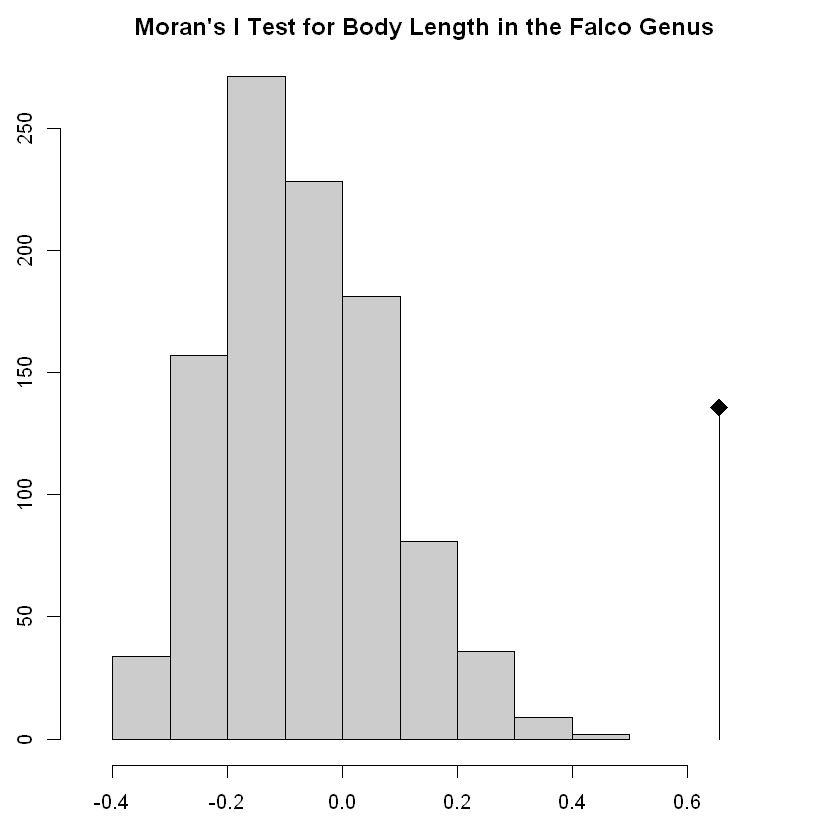

In [46]:
length_4d <- phylo4d(fit$tree, body_len)

length_moran <- abouheif.moran(length_4d, method = "Abouheif")

length_moran

plot(length_moran, main = "Moran's I Test for Body Length in the Falco Genus")

This is a very strong signal, giving us a Moran's coefficient of 0.66 (will differ depending on run). The plot indicates just how strong this relationship is. Therefore, for all four physical traits in question, we have found a moderately strong phylogenetic signal for the Falco genus, as was hypothesized. 



For one last visualization, we can project our phylogeny into morphopspace using our given trait data. This would give us a visual representation of our tree for the continuous values of two traits. However, since we have four traits, we can use the phylogenetic scatterplot matrix from phytools, which will contain the continuous character maps on the diagonals, and the tree representation for two traits on the off-diagonals, giving us a complete picture of the projection of our tree into phylomorphospace using our trait data. This can allow us to ascertain relationships between traits by themselves, and based on the tree data. The function from phytools we can use is called fancyTree() and we will use the scattergram type for our visualization.

Computing multidimensional phylogenetic scatterplot matrix...


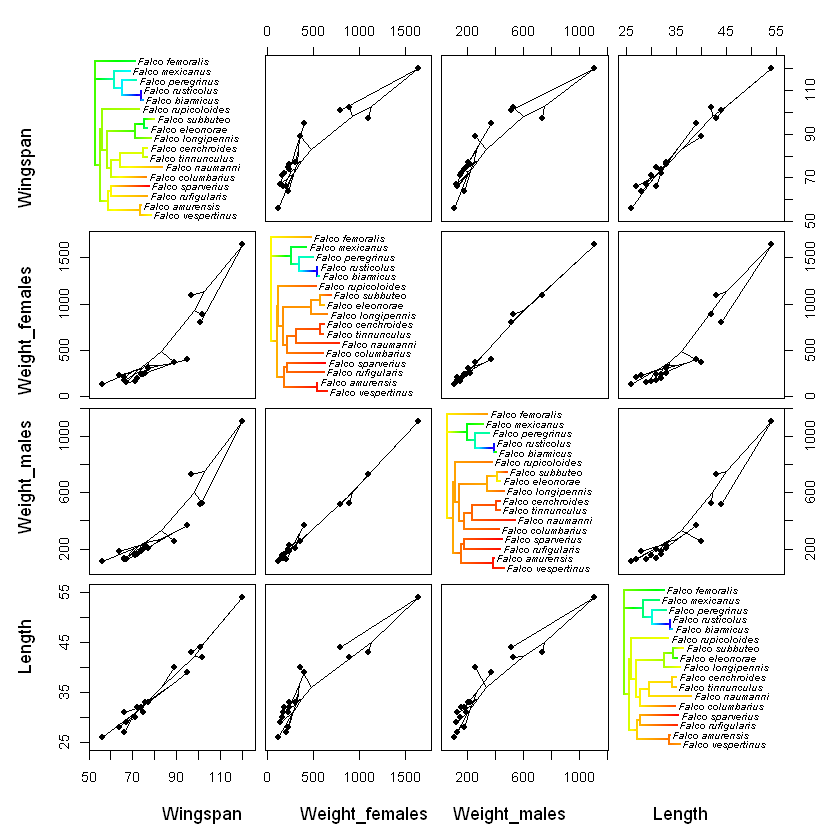

In [49]:
combined_trait <- as.matrix(trait[2:5])

rownames(combined_trait) <- trait$Species

polymorph <- fancyTree(fit$tree,type="scattergram",X=combined_trait, label="off")

We would expect length and weight to be well correlated, and this is the case from what we can see on the scattergram. However, we also see strong correlations between wingspan and the other categories. This might be due to the fact that as weight and length increases, wingspan increase is necessary to compensate in terms of flight. However, this is beyond the scope of this analysis, and we cannot make this assumption as we don't know the dynamics underlying the evolution of the traits. An interesting approach may be to do a comparative trait evolution based on a timeline of evolution for the traits in question, which may give insight into how the traits evolved with respect to each other. 



Overall it was determined that there were moderately strong phylogenetic signals present for all four of the physical traits in question. The following table summarizes the Moran's I test results for the given traits:

In [48]:
phylo_signal_results <- data.frame(c("Wingspan","Body Length", "Female Weight", "Male Weight"), c(wings_moran$obs, length_moran$obs, weight_f_moran$obs, weight_m_moran$obs))

colnames(phylo_signal_results) <- c("Trait","Moran's I Test Result")

phylo_signal_results

Trait,Moran's I Test Result
Wingspan,0.6192131
Body Length,0.6568157
Female Weight,0.6314611
Male Weight,0.5716865


From here we can see that there were moderate positive values for Moran's I coefficient for each of the physical traits. Therefore, our hypothesis that these traits would be well correlated between closely related species was confirmed. Using phylomorphospace scattergram, we were also able to observe that these traits were all well correlated with each other, and within close groupings as well. From this, we can conclude with some accuracy that these traits possibly evolved together, and are relatively conserved between sister species. 



Our analysis has many limitations however, and we will discuss some of them briefly here. As was outlined during the analysis, we did not have COI sequence data for 23 out of 40 of the proposed species for the Falco genus. Therefore, the stability of our trees with respect to the missing data are a potential source of error. It has been shown that neighbor joining is quite sensitive to addition or removal of taxa, and since we started our tree with neighbor joining (although it was optimized and bootstrapped), we have to consider the accuracy of our phylogeny and how it might be compromised because of the missing data. We also made assumptions about the trait data, as we have ranges for the given physical traits, and when we average them we introduce a systematic bias, as the average may not be the best representation of the phenotypic data. Further study on this subject would involve a more complete phylogenetic analysis, however the data necessary is still not available. A more thorough analysis based on an evolutionary timeline might give better insight into how these traits evolved together as well. Using multiple different measures of phylogenetic signaling would provide a more robust confirmation of the relationships found.

***
#### References:



Deagle, B. E., Jarman, S. N., Coissac, E., Pompanon, F., & Taberlet, P. (2014). DNA   metabarcoding and the cytochrome oxidase subunit I marker: not a perfect match. Biology Letters, 10(9). Retrieved from http://rsbl.royalsocietypublishing.org/content/10/9/20140562.abstract



Del Hoyo, J., Elliott, A., Sargatal, J., Christie, D.A. & de Juana, E. (2018). Handbook of the Birds of the World Alive. Lynx Edicions, Barcelona.


Jombart T., Dray S. (2008) adephylo: exploratory analyses for the phylogenetic comparative method.


Münkemüller, T. , Lavergne, S. , Bzeznik, B. , Dray, S. , Jombart, T. , Schiffers, K. and Thuiller, W. (2012), How to measure and test phylogenetic signal. Methods in Ecology and Evolution, 3: 743-756. doi:10.1111/j.2041-210X.2012.00196.x

 

Revell, L. J. (2012) phytools: An R package for phylogenetic comparative biology (and other things). Methods Ecol. Evol. 3 217-223. doi:10.1111/j.2041-210X.2011.00169.x



Schliep K.P. 2011. phangorn: phylogenetic analysis in R. Bioinformatics, 27(4)592-593


Schliep, K., Potts, A. J., Morrison, D. A., Grimm, G. W. (2017), Intertwining phylogenetic trees and networks. Methods in Ecology and Evolution, 8: 1212--1220. doi: 10.1111/2041-210X.12760


Steel, M. (2010). The Phylogenetic Handbook: A Practical Approach to Phylogenetic Analysis and Hypothesis Testing edited by LEMEY, P., SALEMI, M., and VANDAMME, A.-M. Biometrics, 66(1), 324-325. https://doi.org/10.1111/j.1541-0420.2010.01388.x